In [1]:
import pandas as pd

# Load directly from IBM GitHub
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [8]:
df.drop(columns="customerID", axis=1, inplace=True)
print(df.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [9]:
df["Churn"]=df["Churn"].map({"Yes":1, "No":0})
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df=pd.get_dummies(df, drop_first=True)

In [12]:
from sklearn.model_selection import train_test_split
X=df.drop("Churn", axis=1)
y=df["Churn"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[898 135]
 [198 176]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1033
           1       0.57      0.47      0.51       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.76      1407



/Users/vishwa/Documents/Projects/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/Users/vishwa/Documents/Projects/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


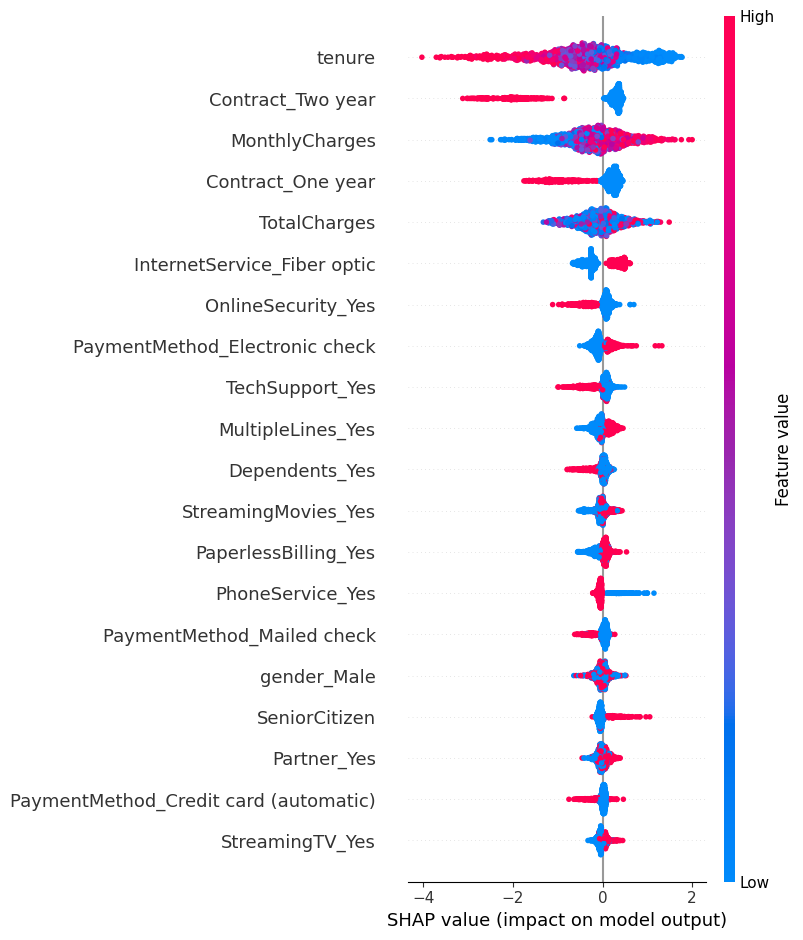

In [14]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [15]:
# Estimating revenue saved if churners are retained
avg_monthly_revenue = df['MonthlyCharges'].mean()
retained_customers = sum((y_test == 1) & (y_pred == 0))
saved_revenue = retained_customers * avg_monthly_revenue

print(f"Estimated Monthly Revenue Saved: ₹{saved_revenue:.2f}")

Estimated Monthly Revenue Saved: ₹12830.05


Text(0.5, 1.0, 'Tenure by Churn')

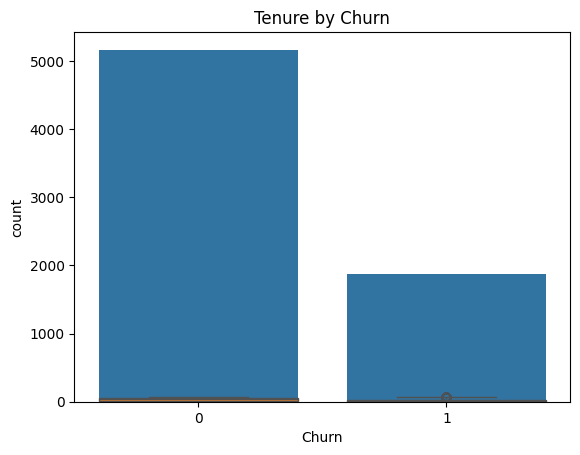

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")

sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure by Churn")

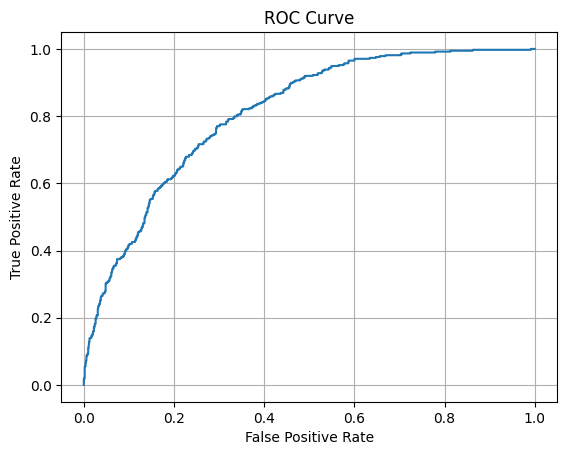

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()